# GCI2020W Competition1 1st Place Solution

## Abstract
この章では、notebookの概要について説明します。

### まえがき

Competition1でスコア0.83で1位となった@PixelPenguinです。
分析に使った全部のコードを載せるとnotebookの長さが3倍くらいになってしまうので、最終提出の再現に必要な最低限のコードと解説だけ載せています。
解説が多めになってしまったので、読みやすくするためにモデル前処理の関数は`titanic_preprocess.py`に移植しnotebook内でimportして使っています。実行の際は`gci_2020_winter_comp1_1st`フォルダをiLectの`/root/userspace/Workspace/competition1/`直下に置いてください(他の場所で実行する場合は`PATH`を適宜書き換えてください)。

連絡はSlackのDMかTwitter(@DrPixelPenguin)へよろしくお願いします。

### 目次

- **[1. Research コンペを理解するための情報収集](#1.-Research)** 
- **[2. EDA データ分析](#2.-EDA)**
- **[3. Preprocess データの前処理](#3.-Preprocess)**
- **[4. Models モデルの訓練と予測](#4.-Models)**
- **[5. Submission 最終予測の作成](#5.-Submission)**
- **[6. Get over 0.83 スコアをさらに上げるために](#6.-Get-over-0.83!)**
- **[7. References 参考](#7.-References)**

---

## 1. Research
この章では、コンペ理解のための情報収集について説明します。

### 1.1. 映画Titanicを観る
Titanicの映画を観ることでEDAや特徴量エンジニアリングに必要な知見を集めました。

コンペを理解するためには当然特徴量や目的変数の把握が必須ですが、問題をちゃんと理解するためには一次情報を集めたり実際に経験したりするのが一番だと思っています。しかし、豪華客船の沈没を経験するのは一生無理だろうし、Titanicに乗っていた知人も居ません。そこで、映画Titanic(1997年公開)をAmazon Primeで200円でレンタルして観ました。今回は外部データの利用が禁止されていましたが、それが許可されている場合は映画を観るなど情報収集をすることで追加した方が良い外部データを思いついたりします。以下に映画を観て生存と関係ありそうな情報をまとめます。

- 部屋の位置

    Titanic号は沈没前に右舷側が氷山と衝突し、船体に想定以上の亀裂が入りました。そして浸水が縦隔壁を越え、まず船首が沈没しました。船尾は持ち上げられ、重さに耐えきれずに船は2つに割れました。最後には結局船尾も沈没してしまいました。よって、**部屋の位置が後方の方が後に沈んだので生存率が高そうな感じがします。**(沈没することが知られてから実際に沈没するまでには数時間あったので、乗客が避難する時間は十分あり、部屋の位置はあまり関係ないかもしれません。)

- 部屋の等級とチケット代金
    
    映画では、Titanic号に備え付けられていた救命ボートがそもそも足りないという話がありました(完全に沈没するフラグ)。そしていざ沈没するときには、1等級(Pclass=1)の客が優先的に救命ボートに誘導され、3等級の客は浸水しているのにフェンスで外に出られないようにされていました。**よって、等級やチケット料が高い客ほど生存率が高そうな感じがします。**
    
- 性別と年齢
    
    救命ボートには等級に関係なく女性と子供が優先的に乗せられていました。1等級の男性でも女性や子供が乗ってから誘導されていました。**よって、子供や女性は等級に関係なく生存率が高そうな感じがします。**
    
- 家族数
    
    ぼっちなら自分の命だけ考えていれば生き残れます。**よって、ぼっち(特に先にボートに乗れる女性)は生存率が高そうな感じがします。**
    
- 家族グループ
    
    家族は避難時もまとまって行動するはずです。さらに、データを観るとtrainとtestに同じ家族が居ます。よって、trainデータの生存率が高い家族はtestデータでも生存率が高そうな感じがします。避難できた子供と女性は同じボートに乗っているはずです。**よって、母親(子供)が生存している子供(母親)は生存率が高そうな感じがします。これが今回スコアを上げる上でかなり貢献してくれました。機械学習モデルは一切使わずに、この情報と同じ情報を使ったkaggleのnotebookを参考にした細かい修正だけでスコアが0.81(KaggleのLB)を超えました。**
    
与えられたデータの特徴量に関係ありそうな情報はこれくらいです。もし外部データを追加するなら

- 乗務員か乗客か(乗務員は避難誘導しなければいけないので避難が遅れ生存率が低そう)
- 招待客かどうか(招待客は優先的に避難誘導されるはずなので生存率が高そう)
- 荷物の量(荷物が多いと避難が遅れそう)

などが有用そうだと思います。

### 1.2. Kaggleのnotebookを読む

KaggleのnotebookにはEDAや特徴量エンジニアリング、モデリングの情報が詰まっているので、手を動かす前に読み漁ります。だいたい20~30個程度読んだので以下にまとめます。

- 前処理(EDA/特徴量エンジニアリング)

    EDAでわかったことは映画を観て思ったことと大体一致。
    
- スコアについて

    - 遺伝的プログラミング(GP)による関数同定(Symbolic regression)がKaggleLBで0.9以上のスコアを出していて現時点で最強。
    - GPの次にWCG(Woman Child Group)モデル(notebookでそう名付けられていたので)とXGBの組み合わせが強い。
    - それ以外の機械学習モデルはだいたい0.8前後で大同小異だが、RFとKNNが若干強い。
    
主なモデルの候補はGenetic Programming, LightGBM, Neural Net, Random Forest, K-NearestNeighborsとWCGにしました。それ以外のモデルも作りましたがスコアはあまり良くなかったです。

---

## 2. EDA
この章では、探索的データ分析について簡単に説明します。他にも色々あるのでkaggleのnotebookを参照してください。

In [6]:
PATH = "C:\\Users\\v77007088\\github\\tokyou-u_chapters\\GCI2020\\competition1\\gci_2020_winter_comp1_1st\\"
import sys
sys.path.append(PATH+'src/')

In [2]:
! pip install lightgbm
! pip install optuna

  Stored in directory: C:\Users\v77007088\AppData\Local\pip\Cache\wheels\b3\18\6d\b86943d5ca51215a50146348518c10bbd9b992f9e36ac59b74
  Stored in directory: C:\Users\v77007088\AppData\Local\pip\Cache\wheels\12\6a\49\94a4af65af2edbccf9f467c0f4b26f24d0e5b61be0d8a7e066
  Stored in directory: C:\Users\v77007088\AppData\Local\pip\Cache\wheels\ff\50\a9\0ddeed8679a1fb65bf4677cb9c92701828b2c1821e22ef72fd
  Stored in directory: C:\Users\v77007088\AppData\Local\pip\Cache\wheels\80\34\1c\3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Stored in directory: C:\Users\v77007088\AppData\Local\pip\Cache\wheels\92\f0\ac\2ba2972034e98971c3654ece337ac61e546bdeb34ca960dc8c
Successfully built optuna alembic Mako PrettyTable pyperclip


In [7]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import lightgbm as lgb
import optuna

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

### 2.1. Adversarial Validation

Adversarial validationによって、trainとtestが均一に分割されているか確認できます。まず、データ全体に訓練データかどうかの特徴量を追加し、それを目的変数としてAUCを最大化するように適当なモデルを訓練させます。AUCが0.5に近ければtrainとtestの分布がほぼ等しいはずです。AUCが高い場合は分割が偏っているので、trainとtestが判別できる特徴量を削除したり、交差検証の際の分割方法を工夫する必要があります。(実際はAUCが0.5に近くても分布が等しい訳ではないらしいのですが詳しいことまでは理解できていないので説明できませんすみません。)

例えば株の時系列データを扱う場合、trainが2018年でtestが2019年のようになっていたら、交差検証をランダムに分割すると未来の情報が使えてしまうので、2018上半期を訓練データ、2018年下半期を検証データのように分割する必要があります。時系列のような簡単な場合はAdversarial Validationは必要ないかもしれません。しかし。例えば今回であればデータには無い何らかの基準で訓練用とテスト用のデータが分割されており両者の分布が異なる可能性があります。一応調べます。

In [8]:
from titanic_preprocess import adversarial_validation_titanic

def load_df(path):
    train = pd.read_csv(path + "input/train.csv")
    test = pd.read_csv(path + "input/test.csv")
    train['IsTrain'] = 1
    test['IsTrain'] = 0
    data = pd.concat([train, test])
    return train, test, data

train, test, data = load_df(PATH)

data.head()

,Age,Cabin,Embarked,Fare,IsTrain,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,1,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,1,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,1,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [10]:
col_to_use_av = [
    'Age',
    'Cabin',
    'Embarked',
    'Fare',
    'IsTrain',
    'Parch',
    'Pclass',
    'Sex',
    'SibSp',
]
_, _, score = adversarial_validation_titanic(data, col_to_use_av)

tune_num_leaves, val_score: 0.616101: 100%|##########| 20/20 [00:01<00:00, 12.96it/s]
tune_bagging_fraction_and_bagging_freq, val_score: 0.616101:   0%|          | 0/10 [00:00<?, ?it/s][I 2020-02-04 13:21:26,104] Finished trial#0 resulted in value: 0.4972319688109162. Current best value is 0.4972319688109162 with parameters: {'bagging_fraction': 0.4335502891274697, 'bagging_freq': 6}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.616101:  10%|#         | 1/10 [00:00<00:00, 11.66it/s][I 2020-02-04 13:21:26,176] Finished trial#1 resulted in value: 0.5972319688109162. Current best value is 0.5972319688109162 with parameters: {'bagging_fraction': 0.8212817704190281, 'bagging_freq': 2}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.616101:  30%|###       | 3/10 [00:00<00:00, 17.59it/s][I 2020-02-04 13:21:26,259] Finished trial#2 resulted in value: 0.6019103313840156. Current best value is 0.6019103313840156 with parameters: {'bagging_fraction': 0.799959819965145, 'bagging_freq

In [6]:
print(score)

0.46454124579124584


trainとtestの分割は偏っていなさそうだと分かりました。よって、モデルの交差検証は訓練データをランダムに分割すれば良さそうです。

### 2.2. 連続変数の相関係数

目的変数との相関係数の絶対値が大きい特徴量が重要そうなので、ヒートマップで調べてみます。

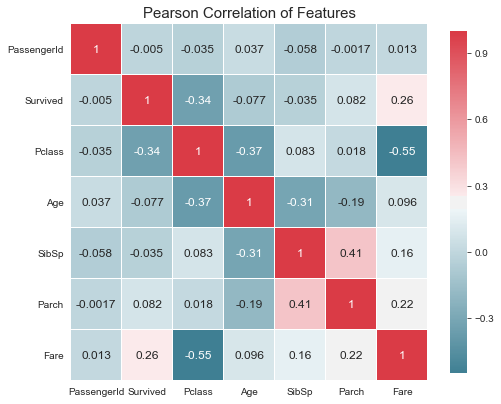

In [11]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(8, 7))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train.drop('IsTrain', axis=1))

FareやPclassがSurvivedとの相関が大きいので重要そうです。

### 2.3. 変数と生存率の関係

まずは、Pclass 1と3で生存率に差があるかどうか調べてみます。

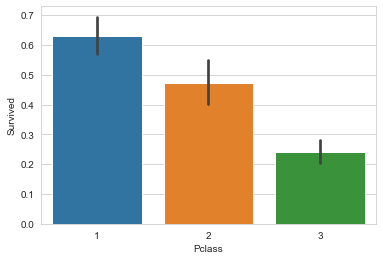

In [12]:
sns.barplot(x = 'Pclass', y = 'Survived', order=[1,2,3], data=train)

1等級と3等級では生存率が倍くらい違うことがわかります。

次に、成人を性別と等級で分けて年齢別に生存/死亡者数を調べます。

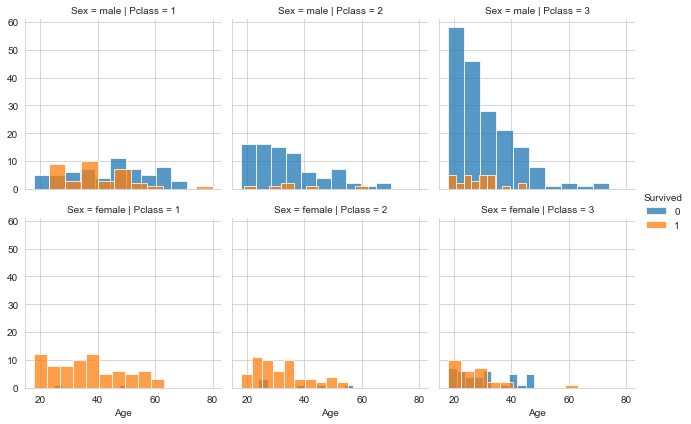

In [13]:
fg = sns.FacetGrid(train[train['Age']>=18], row = 'Sex', col = 'Pclass', hue = 'Survived', aspect=1)
fg.map(plt.hist, 'Age', alpha = .75)
fg.add_legend()

3等級男性はほぼ死亡しているのに対して、3等級女性はほぼ生存していることがわかります。

---

## 3. Preprocess
この章では、モデル訓練のための前処理について説明します。全部載せると長すぎるので、前処理用の関数は全て`titanic_preprocess.py`に書いてあります。

前処理から訓練までの流れは 2.1. Adversarial Validation と同じです。

### 3.1 欠損値処理

最終予測のモデルに使った欠損値補完の概要について説明します。詳細は各コードを参照してください。

- Age
    - 敬称でグルーピングして中央値で補完/回帰モデルで補完
- Cabin
    - 欠損が多いので新しいカテゴリーを作って補完
- Fare
    - 等級や乗船場所でグルーピングして中央値で補完
- Embarked
    - Sで補完(参考にしたnotebookがみんなSで補完していたので)
    
EmbarkedやFareは欠損数が少ないので、全体の平均で埋めたり適当な数値を入れても問題ないような気もします。

### 3.2 特徴量エンジニアリング

最終予測のモデルに使った特徴量エンジニアリングの概要について説明します。詳細は各コードを参照してください。

- kNN (sklearn.neighbors.kNeighbors)

    - 家族サイズの追加
    - 同じ名字、同じチケットでグルーピングして、自分以外のグループ内の生存率を追加
    - Fare, Ageをビニング
    - 標準化(絶対に必要)


- RF (sklearn.ensemble.RandomForestClassifier)

    - Cabinのアルファベットを抽出(Deck)
    - Nameから敬称の抽出
    - 同じ名字での家族のグルーピングと、グループの生存率による特徴量の置換


- WCG (Woman-Child-Group model)

    - 後述
    
---

## 4. Models
この章では、モデルと訓練について説明します。交差検証やKaggle提出を繰り返して各モデルの成績を確認しました。最終予測に使ったのは☆付きのモデルだけなので、それ以外は簡単な説明のみ載せます。

### 4.1. LGB (lightgbm.LGBMClassifier)

まずはLGBを使った予測によってkaggleのLBで0.8以上のスコアを出せました。しかし、最終的にLGB, RF, KNN, WCGを色々組み合わせた結果LGBを使っていないモデルの方がkaggleのLBでスコアが高かったので、最終提出では使っていません。

### 4.2. Symbolic Regression (deap)

遺伝的プログラミングを用いたSymbolic Regressionを使ったnotebookがあり、KaggleのLBで0.9以上のスコアを出していました。しかし、そのモデルはC++で計算したものらしいので使っていません。pythonのdeapライブラリを用いて0.86のスコアを出しているnotebookもありましたが、追試しても何故かスコアが0.8未満で頭打ちでした。よって、遺伝的プログラミングを利用するのは諦めました。これが使えれば圧倒的差で勝てていたので残念......。

### 4.3. Neural Net (pytorch)

テーブルデータのコンペでは、LGBやXGBのようなGBDTモデルとpytorchやkerasによるNeural Netの組み合わせが強いらしいです。しかし自分で組んだNeural NetモデルはkaggleのLBで0.8未満のスコアで頭打ちでした。よって、Neural Netを利用するのは諦めました。

### 4.4. ☆kNN (sklearn.neighbors.KNeighborsClassifier)

最初はkNNを使おうとは一切思っていませんでしたが、チューニングが上手くいったのか意外とスコアが高かったので最終提出で使いました。

- 使うライブラリのimport

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

from titanic_preprocess import (
    preprocess_knn,
    split_preprocessed_data,
)

- データの読み込み、前処理、分割

In [15]:
# データの読み込み
_, _, data = load_df(PATH)
# データの前処理
data = preprocess_knn(data)
# データの分割
col_to_use_knn = [
    'Survived',
    'Pclass',
    'Sex',
    'FamilySize',
    'FamilySurvival',
    'FareBin',
    'AgeBin'
]
X, y, X_test = split_preprocessed_data(data=data,
                                       target='Survived',
                                       col_to_use=col_to_use_knn,
                                       scaler=StandardScaler())

- モデルの訓練

In [16]:
# モデル作成
knn_params = {
    'algorithm': 'auto',
    'leaf_size': 26,
    'metric': 'minkowski', 
    'metric_params': None,
    'n_jobs': 1,
    'n_neighbors': 6,
    'p': 2, 
    'weights': 'uniform'   
}
knn_clf = KNeighborsClassifier(**knn_params)
pipeline_knn = make_pipeline(knn_clf)
# モデル訓練
pipeline_knn.fit(X, y)
# 交差検証
cv_result_knn = cross_validate(pipeline_knn, X, y, cv=10)
print(cv_result_knn['test_score'])
# 予測
y_pred_knn = pipeline_knn.predict(X_test)

[0.81111111 0.87777778 0.78651685 0.87640449 0.87640449 0.84269663
 0.82022472 0.79775281 0.88764045 0.84090909]


- 予測結果の保存

In [17]:
def save_prediction_csv(y_pred, name):
    df = pd.DataFrame(pd.read_csv(PATH + "input/test.csv")['PassengerId'])
    df['Survived'] = y_pred.astype(int)
    df.to_csv(PATH + "output/" + name, index = False)
    
save_prediction_csv(y_pred_knn, 'knn.csv')

### 4.5. ☆RF (sklearn.ensemble.RandomForestClassifier)

これもkNN同様に想定以上にスコアが高かったので最終提出で使いました。(同じ決定木ベースのモデルでもLGBの方がRFより絶対に強いと信じていたので、RFの方がいいスコアが出てかなり意外です。あまり決めつけないで色々なモデルを試した方がいいみたいです。)

- 使うライブラリのimport

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

from titanic_preprocess import (
    preprocess_rf,
    split_preprocessed_data,
)

- データの読み込み、前処理、分割

In [19]:
# データ読み込み
_, _, data = load_df(PATH)
# データ前処理
data = preprocess_rf(data)
# データ分割
col_to_use_rf = [
    'Survived',
    'Pclass',
    'Sex',
    'Age',
    'Fare',
    'Embarked',
    'Title',
    'FamilyLabel',
    'Deck',
    'TicketGroup'
]
X, y, X_test = split_preprocessed_data(data=data,
                                       target='Survived',
                                       col_to_use=col_to_use_rf)

- モデルの訓練

In [20]:
# モデル作成
select = SelectKBest(k=20)
rf_params = {'random_state': 10,
              'warm_start': True,
              'n_estimators': 26,
              'max_depth': 6, 
              'max_features': 'sqrt',
}
rf_clf = RandomForestClassifier(**rf_params)
pipeline_rf = make_pipeline(select, rf_clf)
# モデル訓練
pipeline_rf.fit(X, y)
# 交差検証
cv_result_rf = cross_validate(pipeline_rf, X, y, cv= 10)
print(cv_result_rf['test_score'])
# 予測
y_pred_rf = pipeline_rf.predict(X_test)

[0.84444444 0.85555556 0.76404494 0.8988764  0.87640449 0.82022472
 0.84269663 0.78651685 0.87640449 0.85227273]


- 予測結果の保存

In [21]:
save_prediction_csv(y_pred_rf, 'rf.csv')

### 4.6. ☆Woman Child Group

映画を観て「同じ家族内では母親と子供の生存/死亡はほぼ一致する」と思ったのですが、これを利用してかなり高いスコアを出しているnotebookを見つけました。元のnotebookではRで実装されていたのでPythonに移植しました。

Hand-Labeling感がありますが、調べた限りではHand-Labelingというのは例えば名前を一人ずつ検索して0/1を埋めていく作業であって、このように自分で決定木のような規則を作って分類するのは合法らしいです。(手動で作った単純な規則が機械学習モデルと同等のスコアを出せるのはかなり稀だと思いますが。)

WCGモデルにおけるテストデータの予測方法は、
- 成人男性

    → 死亡
- 1人で乗船した成人女性

    → 生存
- 同じ家族内の女性と子供

    →　同家族が訓練データ内にも存在: 同家族の女性と子供の生存率が1なら生存、1未満なら死亡
    
    →　同家族がテストデータにのみ存在: 1等級なら生存/3等級なら死亡
    
となります。

訓練データを見ると、成人男性はほぼ死亡しており反対にぼっちの成人女性はほぼ生存しているということが分かります。さらに、このコンペの評価指標は正解率です。よって、数少ない成人男性の生存者/ぼっちの成人女性の死亡者を見つけようとして逆にそれらを本来の数よりも多く見積もってしまうと、結局スコアが下がってしまいます。今回は、それぞれのグループの数少ない生存者/死亡者を見つけられる機械学習モデルを訓練できるだけのデータが揃っていなかった結果、単純なWCGモデルがほとんどの機械学習モデルの正解率を上回ったのではないでしょうか。

In [22]:
# データ読み込み
train, test, all_df = load_df(PATH)
all_df.reset_index(inplace=True, drop=True)

# 家族は同じ名字のはずなので名前から名字を抽出します
all_df['LastName'] = all_df['Name'].apply(lambda x: str.split(x, ",")[0])

# Woman-Child-Boyモデルでは、その名の通りデータを
# 成人男性
# 1人で乗船した女性
# 同じ家族(使用人なども含む)内の女性と子供のグループ
# に分割します。
all_df['Gender'] = 'man'
all_df.loc[all_df['Sex'] == 'female', 'Gender'] = 'woman'
all_df.loc[all_df['Name'].str.contains('Master'), 'Gender'] = 'boy'
all_df['GroupId'] = all_df['LastName'].astype(str) \
    + '_' + all_df['Pclass'].astype(str) \
    + '_' + all_df['Ticket'].astype(str).str[:-1] \
    + '_' + all_df['Fare'].astype(str) \
    + '_' + all_df['Embarked'].astype(str)
all_df.loc[all_df['Gender'] == 'man', 'GroupId'] = 'no_group'
all_df.loc[all_df.groupby('GroupId').transform('count')['PassengerId'] <= 1, 'GroupId'] = 'no_group'

# メイド(？)など、「名字は違うけど同じチケットで乗っている人」を探して同じグループ扱いにします。
all_df['TicketId'] = all_df['Pclass'].astype(str) \
    + '_' + all_df['Ticket'].astype(str).str[:-1] \
    + '_' + all_df['Fare'].astype(str) \
    + '_' + all_df['Embarked'].astype(str)
for passenger_id in all_df[(all_df['Gender']!='man') & (all_df['GroupId']=='no_group')]['PassengerId']:
    ticket_id = all_df.loc[all_df['PassengerId']==passenger_id, 'TicketId'].values[0]
    all_df.loc[all_df['PassengerId']==passenger_id, 'GroupId'] = all_df[all_df['TicketId'] == ticket_id]['GroupId'].values[0]
    if all_df[all_df['PassengerId']==passenger_id]['GroupId'].values[0] != 'no_group':
        print(all_df[all_df['PassengerId']==passenger_id]['Name'])

337    Burns, Miss. Elizabeth Margaret
Name: Name, dtype: object
708    Cleaver, Miss. Alice
Name: Name, dtype: object
950    Chaudanson, Miss. Victorine
Name: Name, dtype: object
1032    Daniels, Miss. Sarah
Name: Name, dtype: object
1140    Khalil, Mrs. Betros (Zahie Maria" Elias)"
Name: Name, dtype: object
1258    Riihivouri, Miss. Susanna Juhantytar Sanni""
Name: Name, dtype: object
1262    Wilson, Miss. Helen Alice
Name: Name, dtype: object
1266    Bowen, Miss. Grace Scott
Name: Name, dtype: object
1291    Bonnell, Miss. Caroline
Name: Name, dtype: object


In [23]:
all_df['GroupId'].value_counts()

no_group                                1081
Sage_3_CA. 234_69.55_S                     7
Ryerson_1_PC 1760_262.375_C                6
Asplund_3_34707_31.3875_S                  6
Andersson_3_34708_31.275_S                 6
Goodwin_3_CA 214_46.9_S                    6
Rice_3_38265_29.125_Q                      6
Allison_1_11378_151.55_S                   5
Lefebre_3_413_25.4667_S                    5
Palsson_3_34990_21.075_S                   5
Panula_3_310129_39.6875_S                  5
Skoog_3_34708_27.9_S                       5
Spedden_1_1696_134.5_C                     4
Baclini_3_266_19.2583_C                    4
Fortune_1_1995_263.0_S                     4
Becker_2_23013_39.0_S                      4
Sandstrom_3_PP 954_16.7_S                  3
Carter_1_11376_120.0_S                     3
Wells_2_2910_23.0_S                        3
Zabour_3_266_14.4542_C                     3
Richards_2_2910_18.75_S                    3
Peacock_3_SOTON/O.Q. 310131_13.775_S       3
Coutts_3_C

全体で228人、テストデータでは72人が、同家族の女性と子供のグループ(WCG)に属しています。

In [24]:
# 訓練データ内の女性と子供のグループの平均生存率を計算します。
all_df['GroupMeanSurv'] = None
all_df.loc[all_df['IsTrain']==1, 'GroupMeanSurv'] = \
    all_df[all_df['IsTrain']==1].groupby('GroupId').transform('mean')['Survived']
all_df[(all_df['IsTrain']==1) & (all_df['GroupId']!='no_group')].groupby('GroupId').transform('mean')['Survived'].value_counts()

1.00    89
0.00    59
0.50     4
0.75     4
Name: Survived, dtype: int64

予想通り、同家族の女性と子供はほぼ運命共同体のようです。

In [25]:
# テストデータ内のグループに訓練データ内でのグループの生存率を追加します。
for i in range(len(train), len(all_df)):
    group_id = all_df.loc[i, 'GroupId']
    all_df.loc[i, 'GroupMeanSurv'] = all_df[all_df['GroupId']==group_id]['GroupMeanSurv'].values[0]

In [26]:
# テストデータにのみ存在するグループを探します。
only_in_test_wcg = all_df.loc[all_df['GroupMeanSurv'].isnull()]
only_in_test_wcg[['Age', 'Fare', 'Pclass', 'LastName', 'Gender', 'Name']]

,Age,Fare,Pclass,LastName,Gender,Name
1044,36.00,12.1833,3,Klasen,woman,"Klasen, Mrs. (Hulda Kristina Eugenia Lofqvist)"
1050,26.00,13.7750,3,Peacock,woman,"Peacock, Mrs. Benjamin (Edith Nile)"
1083,11.50,14.5000,3,van Billiard,boy,"van Billiard, Master. Walter John"
1154,1.00,12.1833,3,Klasen,woman,"Klasen, Miss. Gertrud Emilia"
1172,0.75,13.7750,3,Peacock,boy,"Peacock, Master. Alfred Edward"
1235,NaN,14.5000,3,van Billiard,boy,"van Billiard, Master. James William"
1259,45.00,59.4000,1,Gibson,woman,"Gibson, Mrs. Leonard (Pauline C Boeson)"
1293,22.00,59.4000,1,Gibson,woman,"Gibson, Miss. Dorothy Winifred"
1300,3.00,13.7750,3,Peacock,woman,"Peacock, Miss. Treasteall"


1等級の生存率は高く3等級の生存率が低いことがEDAから分かるので、テストデータにのみ存在するグループに関しては、Pclass==1なら生存、Pclass==2なら死亡とします。

In [27]:
# 予測を作成します。
all_df.loc[(all_df['GroupMeanSurv'].isnull()) & (all_df['Pclass']==1), 'GroupMeanSurv'] = 1
all_df.loc[(all_df['GroupMeanSurv'].isnull()) & (all_df['Pclass']==3), 'GroupMeanSurv'] = 0
all_df['WCG'] = 0
all_df.loc[all_df['Gender']=='woman', 'WCG'] = 1
all_df.loc[(all_df['Gender']=='woman') & (all_df['GroupMeanSurv']==0.0), 'WCG'] = 0
all_df.loc[(all_df['Gender']=='boy') & (all_df['GroupMeanSurv']==1.0), 'WCG'] = 1

- 予測結果の保存

In [28]:
y_pred_wcg = all_df[all_df['IsTrain']==0]['WCG'].values
save_prediction_csv(y_pred_wcg, 'wcg.csv')

# 最終提出ではWCGモデルの特徴量を使って3つのモデルをアンサンブルするので、DataFrame全体も保存しておく。
all_df.to_csv(PATH + 'output/wcg_all.csv', index=False)

---

## 5. Submission

この章では、最終予測の作成について説明します。

### 5.1. 最終提出用ファイル作成

Modelsで説明していないモデルも加えてアンサンブルし大量の提出用予測を作りましたが、kaggleのLBでの成績が一番良かったファイルを提出しました。(kaggleのLBで0.847でしたが最終的には0.83まで落ちました。)

交差検証のスコアとLBのスコアのどちらを信用すれば良いのかは正直分かりません......。6で説明しますが、交差検証とチューニングを同時に行なっていたため、モデルが訓練用データに過学習していたらしいということが分かりました。そのため、今回は交差検証のスコアよりもLBのスコアを信用したのが結果的に功を奏したのでしょうか。ただ、LBに過学習してしまう問題もあるみたいなので難しいです。

In [29]:
# データの読み込み
test = pd.read_csv(PATH+'input/test.csv')
knn = pd.read_csv(PATH+'output/knn.csv')
rf = pd.read_csv(PATH+'output/rf.csv')
wcg = pd.read_csv(PATH+'output/wcg.csv')
group = pd.read_csv(PATH+'output/wcg_all.csv')
group = group[group['IsTrain']==0].reset_index(drop=True)

# 同家族の女性と子供のグループ: WCGの予測を利用
# 男性: RFの予測を利用
# 1人女性: kNNの予測を利用
test['Survived'] = wcg['Survived']
man_bool = group['Gender'] == 'man'
test.loc[man_bool, 'Survived'] = rf[man_bool]['Survived']
alone_woman_bool = (group['Gender'] == 'woman') & (group['GroupId'] == 'no_group')
test.loc[alone_woman_bool, 'Survived'] = knn[alone_woman_bool]['Survived']

# 保存
save_prediction_csv(test['Survived'].values, 'submission.csv')
# test[['PassengerId', 'Survived']].to_csv(PATH+'output/submission.csv', index=False)

---

## 6. Get over 0.83!

この章では、スコアをさらに上げる方法について説明します。

### 6.1. 特徴量エンジニアリング

- featuretoolsによる総当たり特徴量エンジニアリング
- 次元削減による特徴量追加
- クラスタリングによる特徴量追加

などなど、次回以降使ってみたいと思います。

### 6.2. Stacking

アンサンブルは複数のモデルの予測結果の加重平均を取るなどして最終予測をします。一方で、スタッキングはモデルの予測結果を別のモデルの入力として用いる方法です。この方法も試してみましたが、全然スコアが上がりませんでした。

コンペの締め切り後に失敗の理由を調べたところ、モデルのハイパーパラメータチューニングと交差検証を同時に行ったために、モデルが訓練用データに過学習していることが原因らしいとわかりました。**(交差検証のスコアよりもLBのスコアが下がりがちだったのはこれが原因だと思います。)**

過学習を抑えてスタッキングをするには、訓練用データを学習用/調整用/検証用に分けるNested Cross Validationを用いるのが良いそうなので、次回以降のコンペで使ってみたいと思います。

### 6.2. Nested Cross Validation

訓練用データを学習用/調整用/検証用に分け二重の交差検証をする方法をNested Cross Validationと言います。パラメータチューニングを交差検証と同時に行うと、モデルがすでに見た汚れたデータでモデルを評価することになるので過大評価してしまいます。Nested CVによりそれを回避できます。

欠点として、
- 計算時間が増える。
- 分割ごとのデータの分布が異なると正当に検証できない。
- 分割ごとにモデルのチューニングを行うので、結局どのパラメータの組み合わせが最善なのかわからない。

ことが挙げられていました。

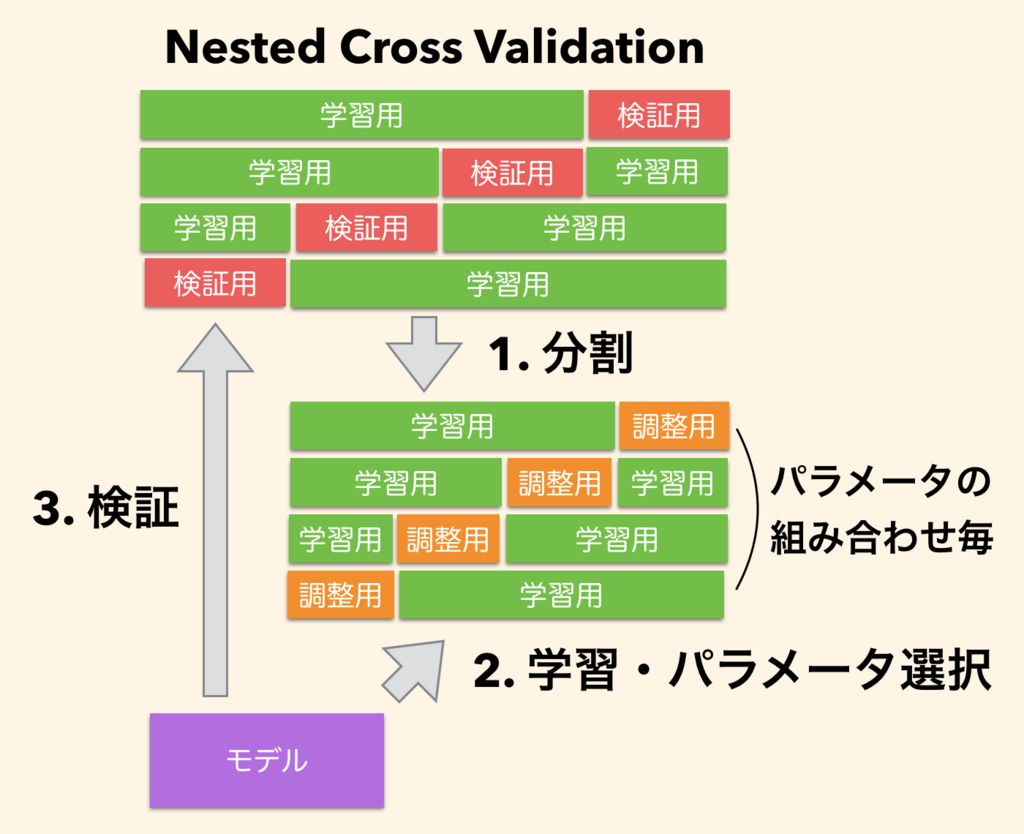

from: [パラメータ探索を伴う機械学習モデルの交差検証について](https://blog.amedama.jp/entry/2018/07/23/084500)

これ以外にも出来ることは無限にあると思います。

---

## 7. References

[もみじあめさんのブログ](https://blog.amedama.jp/)はおすすめです。


https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

https://www.kaggle.com/paulorzp/titanic-gp-model-training

https://www.kaggle.com/ailobster/python-titanic-predictions-top-3

https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210

https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial

https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83

https://www.kaggle.com/vincentlugat/200-lines-randomized-search-lgbm-82-3

https://www.kaggle.com/cdeotte/titanic-using-name-only-0-81818

https://blog.amedama.jp/entry/2018/07/23/084500

https://blog.amedama.jp/entry/featuretools-brute-force-feature-engineering
